## Import Libraries

In [1]:
## Install prophet if not already installed
#!pip install prophet

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from datetime import date
import yfinance as yf
import matplotlib.pyplot as plt
import math
from prophet import Prophet
import itertools
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import add_changepoints_to_plot

## Data Collection/Processing

[*********************100%***********************]  1 of 1 completed


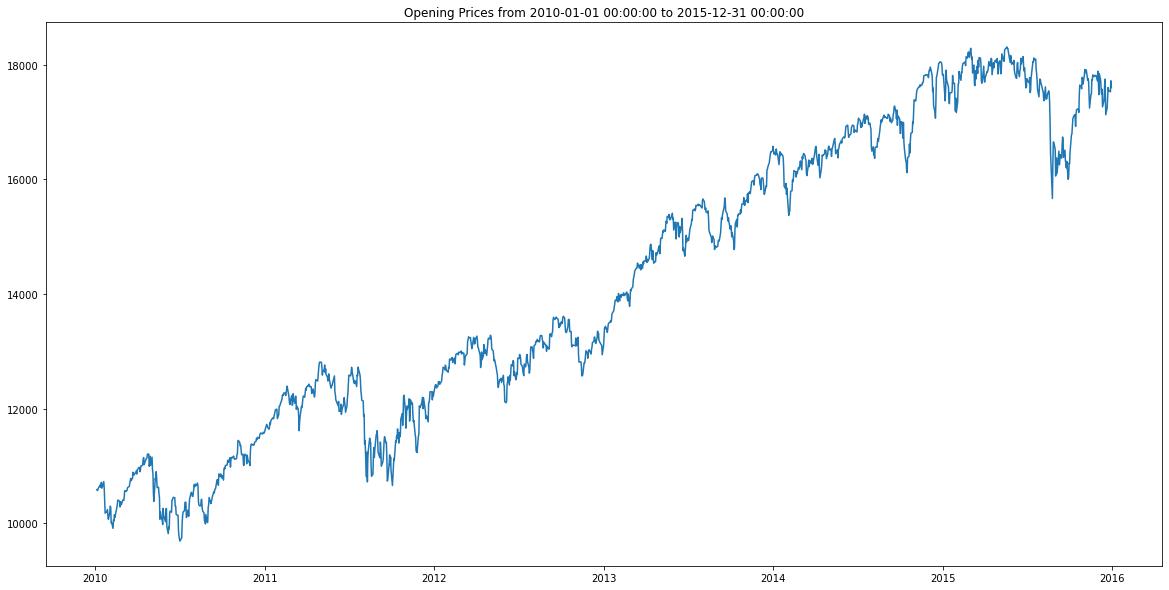

In [3]:
# Select date range
start_date = datetime(2010, 1, 1)
#end_date = date.today()
end_date = datetime(2015, 12, 31)
  
# Download ticker data from Yahoo Finance
ticker = 'DJIA'
data = yf.download(ticker, start = start_date,
                   end = end_date)
target = 'Adj Close'
  
# Visualization
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start_date,
                                                end_date))
plt.plot(data[target])
plt.show()

In [4]:
# Preview data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,10430.690430,10641.620117,10430.690430,10583.959961,10583.959961,3991400000
2010-01-05,10584.559570,10647.139648,10468.860352,10572.019531,10572.019531,2491020000
2010-01-06,10564.719727,10655.219727,10488.280273,10573.679688,10573.679688,4972660000
2010-01-07,10571.110352,10655.599609,10471.730469,10606.860352,10606.860352,5270680000
2010-01-08,10606.400391,10653.110352,10509.740234,10618.190430,10618.190430,4389590000


In [5]:
# Set Target Variable
target = 'Adj Close'
df = pd.DataFrame(data[target], index=data.index)
df.reset_index(inplace=True)
df.head()

,Date,Adj Close
0,2010-01-04,10583.959961
1,2010-01-05,10572.019531
2,2010-01-06,10573.679688
3,2010-01-07,10606.860352
4,2010-01-08,10618.190430


In [6]:
# Prophet requires a specific format of data with designated column names, so let's change them
df=df.rename(columns={"Date": "ds", target: "y"})
df.head()

,ds,y
0,2010-01-04,10583.959961
1,2010-01-05,10572.019531
2,2010-01-06,10573.679688
3,2010-01-07,10606.860352
4,2010-01-08,10618.190430


## Train Prophet Model

In [7]:
## Define Prophet model
model = Prophet()
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
## We can cross validate here
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon = '365 days')
df_cv

INFO:prophet:Making 5 forecasts with cutoffs between 2013-01-09 00:00:00 and 2014-12-30 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-01-10,13378.706722,13107.876344,13656.084130,13471.219727,2013-01-09
1,2013-01-11,13377.432860,13103.388102,13634.856839,13488.429688,2013-01-09
2,2013-01-14,13380.810403,13126.226067,13649.227500,13507.320312,2013-01-09
3,2013-01-15,13384.702662,13119.474911,13652.407267,13534.889648,2013-01-09
4,2013-01-16,13373.768851,13103.748414,13648.068182,13511.230469,2013-01-09
...,...,...,...,...,...,...
1253,2015-12-23,19566.976551,16723.157523,22357.741016,17602.609375,2014-12-30
1254,2015-12-24,19588.498355,16738.573122,22383.693934,17552.169922,2014-12-30
1255,2015-12-28,19648.376549,16706.748199,22492.261267,17528.269531,2014-12-30
1256,2015-12-29,19679.032849,16739.239352,22583.761861,17720.980469,2014-12-30


In [9]:
## We can also observe the performance metrics corresponding to the cross-validation
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,299632.502895,547.386977,427.558041,0.027402,0.019782,0.027217,0.480000
1,38 days,309204.720248,556.061795,435.487201,0.027881,0.020030,0.027677,0.472000
2,39 days,319265.656983,565.035978,443.260801,0.028367,0.020434,0.028144,0.464000
3,40 days,328235.448688,572.918361,449.831908,0.028780,0.021010,0.028536,0.461333
4,41 days,339855.559919,582.971320,460.491905,0.029476,0.022422,0.029228,0.448000


In [10]:
## Hyperparameter Tuning w/ grid search

# Define param grid
param_grid = {  
    'changepoint_prior_scale': [0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 7 forecasts with cutoffs between 2012-01-15 00:00:00 and 2014-12-30 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 7 forecasts with cutoffs between 2012-01-15 00:00:00 and 2014-12-30 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 7 forecasts with cutoffs between 2012-01-15 00:00:00 and 2014-12-30 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 7 forecasts with cutoffs between 2012-01-15 00:00:00 and 2014-12-30 00:00:00



   changepoint_prior_scale  seasonality_prior_scale         rmse
0                      0.1                      0.1  1195.688919
1                      0.1                      1.0  1224.575584
2                      0.5                      0.1  1729.483438
3                      0.5                      1.0  1949.606534


In [11]:
## Save parameters of best performing model
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


## Forecasting

In [12]:
## Train/Test Split
split_date = '2015-01-01'
train = df[df['ds'] < split_date]
test = df[df['ds'] >= split_date]
train.shape, test.shape

((1258, 2), (251, 2))

In [13]:
## Define best_model based on grid search above
best_model = Prophet(changepoint_prior_scale = best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale = best_params['seasonality_prior_scale']
                    )
best_model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
## Setup forecast dataframe using helper function
future = best_model.make_future_dataframe(periods=len(test))
future

,ds
0,2010-01-04
1,2010-01-05
2,2010-01-06
3,2010-01-07
4,2010-01-08
...,...
1504,2015-09-04
1505,2015-09-05
1506,2015-09-06
1507,2015-09-07


In [15]:
## Make forecasts
forecast = best_model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,10209.814611,10084.575502,10694.313939,10209.814611,10209.814611,181.520264,181.520264,181.520264,-5.705987,-5.705987,-5.705987,187.226251,187.226251,187.226251,0.0,0.0,0.0,10391.334876
1,2010-01-05,10214.110507,10129.538190,10711.008282,10214.110507,10214.110507,203.009491,203.009491,203.009491,5.737719,5.737719,5.737719,197.271773,197.271773,197.271773,0.0,0.0,0.0,10417.119998
2,2010-01-06,10218.406402,10152.937708,10718.290885,10218.406402,10218.406402,201.957388,201.957388,201.957388,-4.199749,-4.199749,-4.199749,206.157137,206.157137,206.157137,0.0,0.0,0.0,10420.363790
3,2010-01-07,10222.702297,10140.743032,10721.894598,10222.702297,10222.702297,216.144629,216.144629,216.144629,2.468227,2.468227,2.468227,213.676402,213.676402,213.676402,0.0,0.0,0.0,10438.846926
4,2010-01-08,10226.998192,10148.339504,10735.052764,10226.998192,10226.998192,223.991459,223.991459,223.991459,4.346577,4.346577,4.346577,219.644882,219.644882,219.644882,0.0,0.0,0.0,10450.989651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2015-09-04,18832.264173,15469.156119,21527.804213,15863.141674,21821.755767,-291.915554,-291.915554,-291.915554,4.346577,4.346577,4.346577,-296.262131,-296.262131,-296.262131,0.0,0.0,0.0,18540.348619
1505,2015-09-05,18837.021886,15546.222375,21594.229840,15853.100538,21846.772216,-286.332722,-286.332722,-286.332722,-1.323395,-1.323395,-1.323395,-285.009327,-285.009327,-285.009327,0.0,0.0,0.0,18550.689165
1506,2015-09-06,18841.779600,15519.956928,21628.248202,15843.059402,21883.608382,-274.470822,-274.470822,-274.470822,-1.323391,-1.323391,-1.323391,-273.147431,-273.147431,-273.147431,0.0,0.0,0.0,18567.308778
1507,2015-09-07,18846.537314,15487.894468,21661.433371,15824.469536,21919.402915,-266.552558,-266.552558,-266.552558,-5.705987,-5.705987,-5.705987,-260.846571,-260.846571,-260.846571,0.0,0.0,0.0,18579.984755


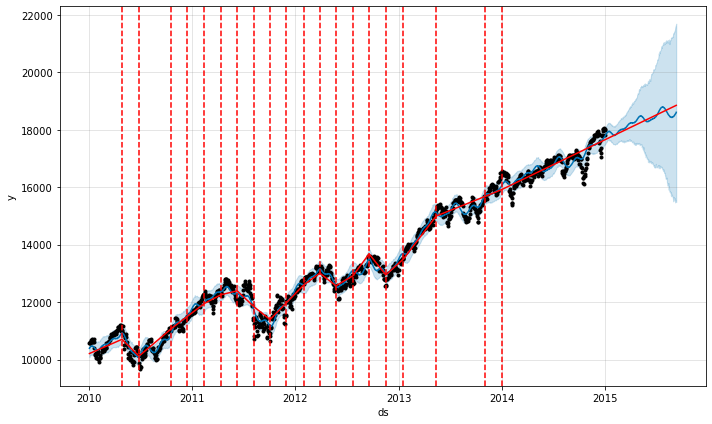

In [16]:
## Plot forecasts
fig = best_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), best_model, forecast)

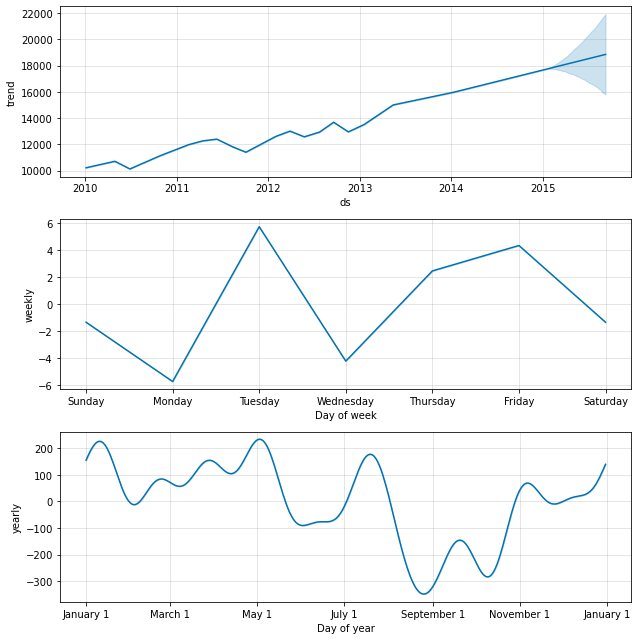

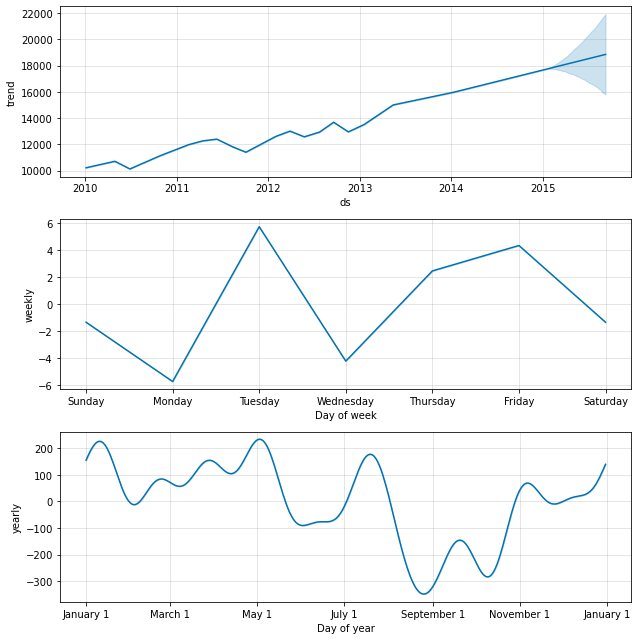

In [17]:
## Plot breakdown of forecast components
fig2 = best_model.plot_components(forecast)
fig2

## Performance Evaluation

In [18]:
## Performance metrics
preds = forecast[forecast['ds'] >= split_date]['yhat']
actual = test['y']
preds.index = actual.index = test.ds
mse = mean_squared_error(actual, preds)
print('MSE: '+str(mse))
mae = mean_absolute_error(actual, preds)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(actual, preds))
print('RMSE: '+str(rmse))

MSE: 991902.2940701084
MAE: 740.8531674033729
RMSE: 995.9429170741205


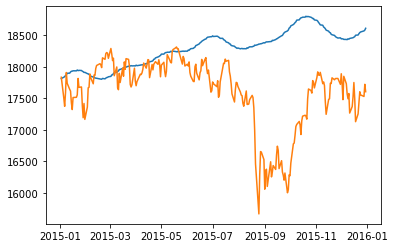

In [19]:
## We can see from below that the model does not quite pickup the sudden drop in 2015/09.
## These types of "flash crashes" are obviously hard to pick up from a modeling standpoint, as it does not follow historic patterns.
## https://www.cnbc.com/2015/09/25/what-happened-during-the-aug-24-flash-crash.html 
plt.plot(pd.Series(preds))
plt.plot(pd.Series(actual))